In [1]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np

# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt

# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib

# pandas用ライブラリ
import pandas as pd

# データフレーム表示用関数
from IPython.display import display

# seaborn
import seaborn as sns

# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode="fixed")
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams["figure.figsize"] = (6, 6)
# 方眼表示ON
plt.rcParams["axes.grid"] = True
# データフレームでの表示精度
pd.options.display.float_format = "{:.3f}".format
# データフレームですべての項目を表示
pd.set_option("display.max_columns", None)

In [2]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.25.1
Running on ArViz v0.22.0


In [3]:
# パラメータ設定
p = 0.5
# p はベルヌーイ分布の成功確率（くじに「当たる」確率）を表すパラメータ。
# 理論的には、確率変数 X が
#
#   X ∼ Bernoulli(p)
#
# に従うとき、
#
#   P(X = 1) = p,   P(X = 0) = 1 - p
#
# という 2 値（0 or 1）の分布を表す。
# 今回は p = 0.5 としているので、「当たり」と「ハズレ」が等確率の対称なベルヌーイ分布になっている。

model1 = pm.Model()
# model1 は PyMC における「確率モデル（ベイズモデル）」のコンテナ。
# 理論的には、この model1 の中に
#
#   - パラメータ（事前分布） p(θ)
#   - 観測変数（尤度） p(x | θ)
#
# を順次定義していくことで、ベイズモデル全体
#
#   p(θ, x) = p(x | θ) p(θ)
#
# を表現することになる。
# ここではまだパラメータに事前分布は与えておらず、単一のベルヌーイ分布に従う
# 生成モデル X ~ Bernoulli(p) を記述する最小限のモデルになっている。

with model1:
    # with 文によるコンテキスト内で定義された確率変数は、すべて上で作成した model1 に登録される。
    # 理論的には、「このブロックの中に書かれる分布と変数は、同一の確率モデルの構成要素である」
    # という宣言だと思ってよい。
    #
    # pm.Bernoulli: ベルヌーイ分布の確率変数を定義するクラス。
    #   X ∼ Bernoulli(p)
    # に対応し、0/1 の 2 値をとる離散分布を表す。
    #
    # p: くじに当たる確率（成功確率）。
    #   - 理論的には「1 回の試行において X=1 となる確率」
    #   - 今回は p=0.5 固定なので、
    #
    #       P(X = 1) = 0.5,  P(X = 0) = 0.5
    #
    #     の対称なベルヌーイ分布。
    #
    # 'x': 確率変数の名前（ラベル）。
    #   - PyMC 内部では、このラベルをキーとして事前・事後サンプルにアクセスする。
    #   - 理論的には、0/1 をとるランダム変数 X をコード上で識別するためのハンドルだと考えられる。
    #
    # この時点では observed 引数を指定していないため、
    #
    #   X ∼ Bernoulli(p=0.5)
    #
    # という「生成モデル」だけが定義されている状態である。
    # もし観測データ x_obs が 0/1 のサンプルとして与えられているなら、
    #
    #   x = pm.Bernoulli('x', p=p, observed=x_obs)
    #
    # のように書くことで、
    #
    #   p(x_obs | p)
    #
    # という尤度をモデルに組み込むことができる。
    # さらに p 自体にも事前分布（例: p ∼ Beta(α, β)）を与えると、
    #
    #   p ∼ Beta(α, β)
    #   x | p ∼ Bernoulli(p)
    #
    # というベイズモデルが構成され、観測データから p の事後分布
    #
    #   p(p | x_obs) ∝ p(x_obs | p) p(p)
    #
    # を PyMC の MCMC で推定できるようになる、というのが理論的な流れである。
    x = pm.Bernoulli("x", p=p)

In [4]:
with model1:
    # with model1: によって、このブロック内で呼び出す関数は
    # すべて「先ほど定義したベルヌーイ分布モデル model1」に紐づいて実行される。
    #
    # model1 の中身（現時点）：
    #
    #   X ∼ Bernoulli(p=0.5)
    #
    # という 0/1 の確率変数が 1 つだけ存在する単純な生成モデル。
    # ここでは p 自体は確率変数ではなく「既知の定数 0.5」として扱われている。
    #
    # pm.sample_prior_predictive:
    #   ベイズ統計でいう「事前予測分布 (prior predictive distribution)」に従う
    #   サンプルを生成する関数に対応する。
    #
    # 一般のベイズモデルでは
    #
    #   θ ∼ p(θ)        （パラメータの事前分布）
    #   x ∼ p(x | θ)    （尤度／データ生成モデル）
    #
    # と書けるとき、事前予測分布は
    #
    #   p(x) = ∫ p(x | θ) p(θ) dθ
    #
    # で定義される。
    #
    # pm.sample_prior_predictive() はこの p(x) からサンプルを生成する操作を
    # 数値的に模倣しており、
    #
    #   1. θ^(s) ~ p(θ) をサンプル
    #   2. x^(s) ~ p(x | θ^(s)) をサンプル
    #
    # を繰り返すことで {x^(s)} を得る、というイメージに対応する。
    #
    # ただし今回のモデルでは θ に相当するパラメータ p が確率変数ではなく定数 0.5 なので、
    #
    #   X ∼ Bernoulli(p=0.5)
    #
    # という 1 段階の生成しかなく、
    #
    #   p(x) = p(x | p=0.5)
    #
    # という「退化した事前予測分布」になっている。
    # それでも sample_prior_predictive は、
    #   X ~ Bernoulli(0.5)
    # からのサンプル列 {X^(s)} を生成し、
    # 「このモデルが事前に想定しているデータ分布」を具体的な乱数として与えてくれる。
    #
    # random_seed=42:
    #   サンプリングに用いる乱数シードを固定することで、
    #   毎回同じ {X^(s)} が得られるようにしている。
    #   ベイズ推論はサンプルベースの推定を行うため、
    #   結果の再現性を確保するには乱数シードを明示することが重要。
    prior_samples1 = pm.sample_prior_predictive(random_seed=42)

Sampling: [x]


In [5]:
# prior_samples1 は pm.sample_prior_predictive(...) の戻り値であり、
# その中の ['prior']['x'] は、
#
#   X ∼ Bernoulli(p=0.5)
#
# という事前モデルから生成されたサンプル列 {X^(s)} を保持している。
# PyMC/ArviZ では通常、InferenceData の "prior" グループに
#   (チェーン数, ドロー数, …)
# のような形状でサンプルが格納されているため、
# .values で NumPy 配列として取り出している。
#
# 理論的には、この x_samples1 は
#
#   X^(s) ∈ {0, 1}  ,  s = 1, …, S
#
# というベルヌーイ分布 Bernoulli(0.5) に従う標本であり、
# 経験分布を通じて真の分布
#
#   P(X = 1) = 0.5,  P(X = 0) = 0.5
#
# をサンプルベースで近似していると解釈できる。
x_samples1 = prior_samples1["prior"]["x"].values

# 生成されたサンプル列をそのまま出力する。
# 出力される値は 0 と 1 のみからなり、
#   - 1 の比率が「当たり」の経験的な確率
#   - 0 の比率が「ハズレ」の経験的な確率
# に対応する。
#
# サンプルサイズを S とすると、
#
#   1 の経験頻度
#     \hat{p} = (1/S) ∑_{s=1}^S 1{X^(s) = 1}
#
# は大数の法則により S → ∞ のとき真の p = 0.5 に収束する。
# したがって、この print 出力を眺めること自体が、
# 「事前モデル Bernoulli(0.5) からのサンプルが期待通り 0/1 を半々くらいで出しているか」
# を感覚的に確認する簡易チェックになっている。
print(x_samples1)

[[1 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 0 1 0 1 1 1
  0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0
  0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 1 1 1 0 1
  1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1
  1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 1 1
  0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1
  1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1
  0 0 0 1 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 1
  1 0 0 1 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0
  1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 1 0
  1 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1
  0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0
  1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1
  0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 1 0 0 

In [6]:
# ArviZ の summary 関数を用いて、事前サンプル prior_samples1 の要約統計量を計算する。
# az.summary(...) は本来、事後サンプル（posterior）に対して
#   - 平均 (mean)
#   - 標準偏差 (sd)
#   - HDI（Highest Density Interval：最も密度の高い信用区間）
#   - ESS（有効サンプルサイズ）
#   - R-hat（収束診断指標）
# などを表形式で返すための関数だが、
# InferenceData であれば prior（事前）にも同様の統計量を計算できる。
#
# 今回 prior_samples1 は
#
#   X ∼ Bernoulli(p=0.5)
#
# からの事前サンプル {X^(s)} を含んでいる。
# 理論的には、X の分布は
#
#   P(X = 1) = 0.5,  P(X = 0) = 0.5
#
# なので、
#
#   期待値:
#
# $$
# \mathbb{E}[X] = 0 \cdot (1 - p) + 1 \cdot p = p = 0.5
# $$
#
#   分散:
#
# $$
# \mathrm{Var}(X) = p(1 - p) = 0.25
# $$
#
#   標準偏差:
#
# $$
# \sigma = \sqrt{0.25} = 0.5
# $$
#
# となる。
#
# az.summary(prior_samples1, kind='stats') は、サンプル {X^(s)} に基づいて
# これらの量をモンテカルロ的に推定していると解釈できる。
# サンプル数 S が十分大きければ、
#
#   - summary1["mean"] ≈ 0.5
#   - summary1["sd"]   ≈ 0.5
#
# となり、理論値と良い一致を示すはずである。
# これは「PyMC の事前サンプルが、期待したベルヌーイ分布 Bernoulli(0.5) に従っているか」を
# 数値的にチェックする一つの方法になっている。
summary1 = az.summary(prior_samples1, kind="stats")

# 得られた要約統計量 summary1 を表示する。
# Jupyter 環境では display(summary1) によって、pandas の DataFrame 形式の表が見やすくレンダリングされる。
# 表の中の mean, sd, hdi_xx などの値を理論値と比較することで、
# 事前分布（あるいは事前予測分布）の統計的な性質が
# 想定しているモデル（ここでは Bernoulli(0.5)）と整合しているかを確認できる。
display(summary1)

,mean,sd,hdi_3%,hdi_97%
x,0.512,0.500,0.000,1.000


Text(0.5, 1.0, 'ベルヌーイ分布\u3000p=0.5')

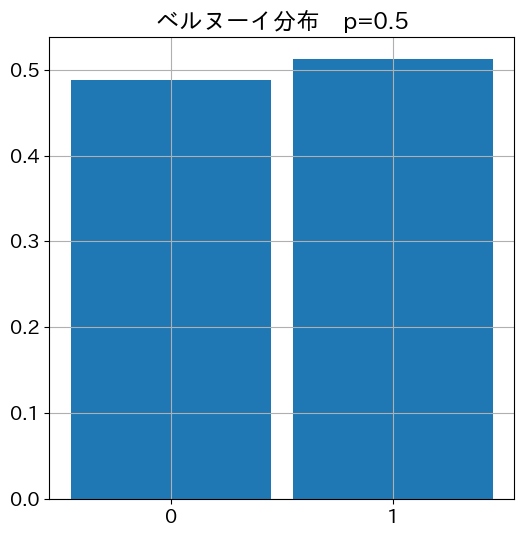

In [7]:
# ArviZ を用いて、ベルヌーイ分布からの事前サンプル x_samples1 の分布を可視化する。
# x_samples1 は
#
#   X^{(s)} ∈ {0, 1},  s = 1, …, S
#
# というサンプル列であり、理論的には
#
#   X ∼ Bernoulli(p)
#
# の事前分布（あるいは事前予測分布）からの標本とみなせる。
# 大数の法則により、サンプル数 S → ∞ のとき、経験分布は真の分布
#
#   P(X = 1) = p,   P(X = 0) = 1 - p
#
# に収束するので、このプロットは有限サンプルに基づく「ベルヌーイ分布の経験的な形」を示している。
ax = az.plot_dist(x_samples1)

# プロットにタイトルを付ける。
# タイトル 'ベルヌーイ分布 p=0.5'（具体的には f 文字列で p の値を埋め込む）は、
# この図が「どの確率分布に対応するサンプルを可視化したものか」を明示する役割を持つ。
#
# 理論的には、ここで描画されているのは
#
#   X ∼ Bernoulli(p)
#
# の経験分布（サンプルベースの近似）であり、
# - p が 0.5 であれば 0 と 1 がほぼ半々で現れる対称な形
# - p が 0.8 などに変われば、1 側に質量が偏った形
#
# になるはずである。
# つまり、同じコードで p の値を変えながら x_samples1 を取り直し可視化することで、
# 「ベルヌーイ分布のパラメータ p が変わると分布の形がどう変わるか」を
# ベイズ的なサンプル視点から確認できる。
ax.set_title(f"ベルヌーイ分布　p={p}")